In [ ]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# Stellar-Mass vs. Halo-Mass Relation

In [ ]:
mhalo = np.logspace(10, 15, 100)

## Guo et al. 2010

In [ ]:
guo = holo.observations.Guo_2010()
mstar = guo.stellar_mass(mhalo * MSOL) / MSOL

fig, ax = plt.subplots(figsize=[10, 6])
ax.set(xscale='log', yscale='log')
ax.grid(True)

ax.plot(mhalo, mstar)

plt.plot

<b>plot from the paper:</b>
<div>
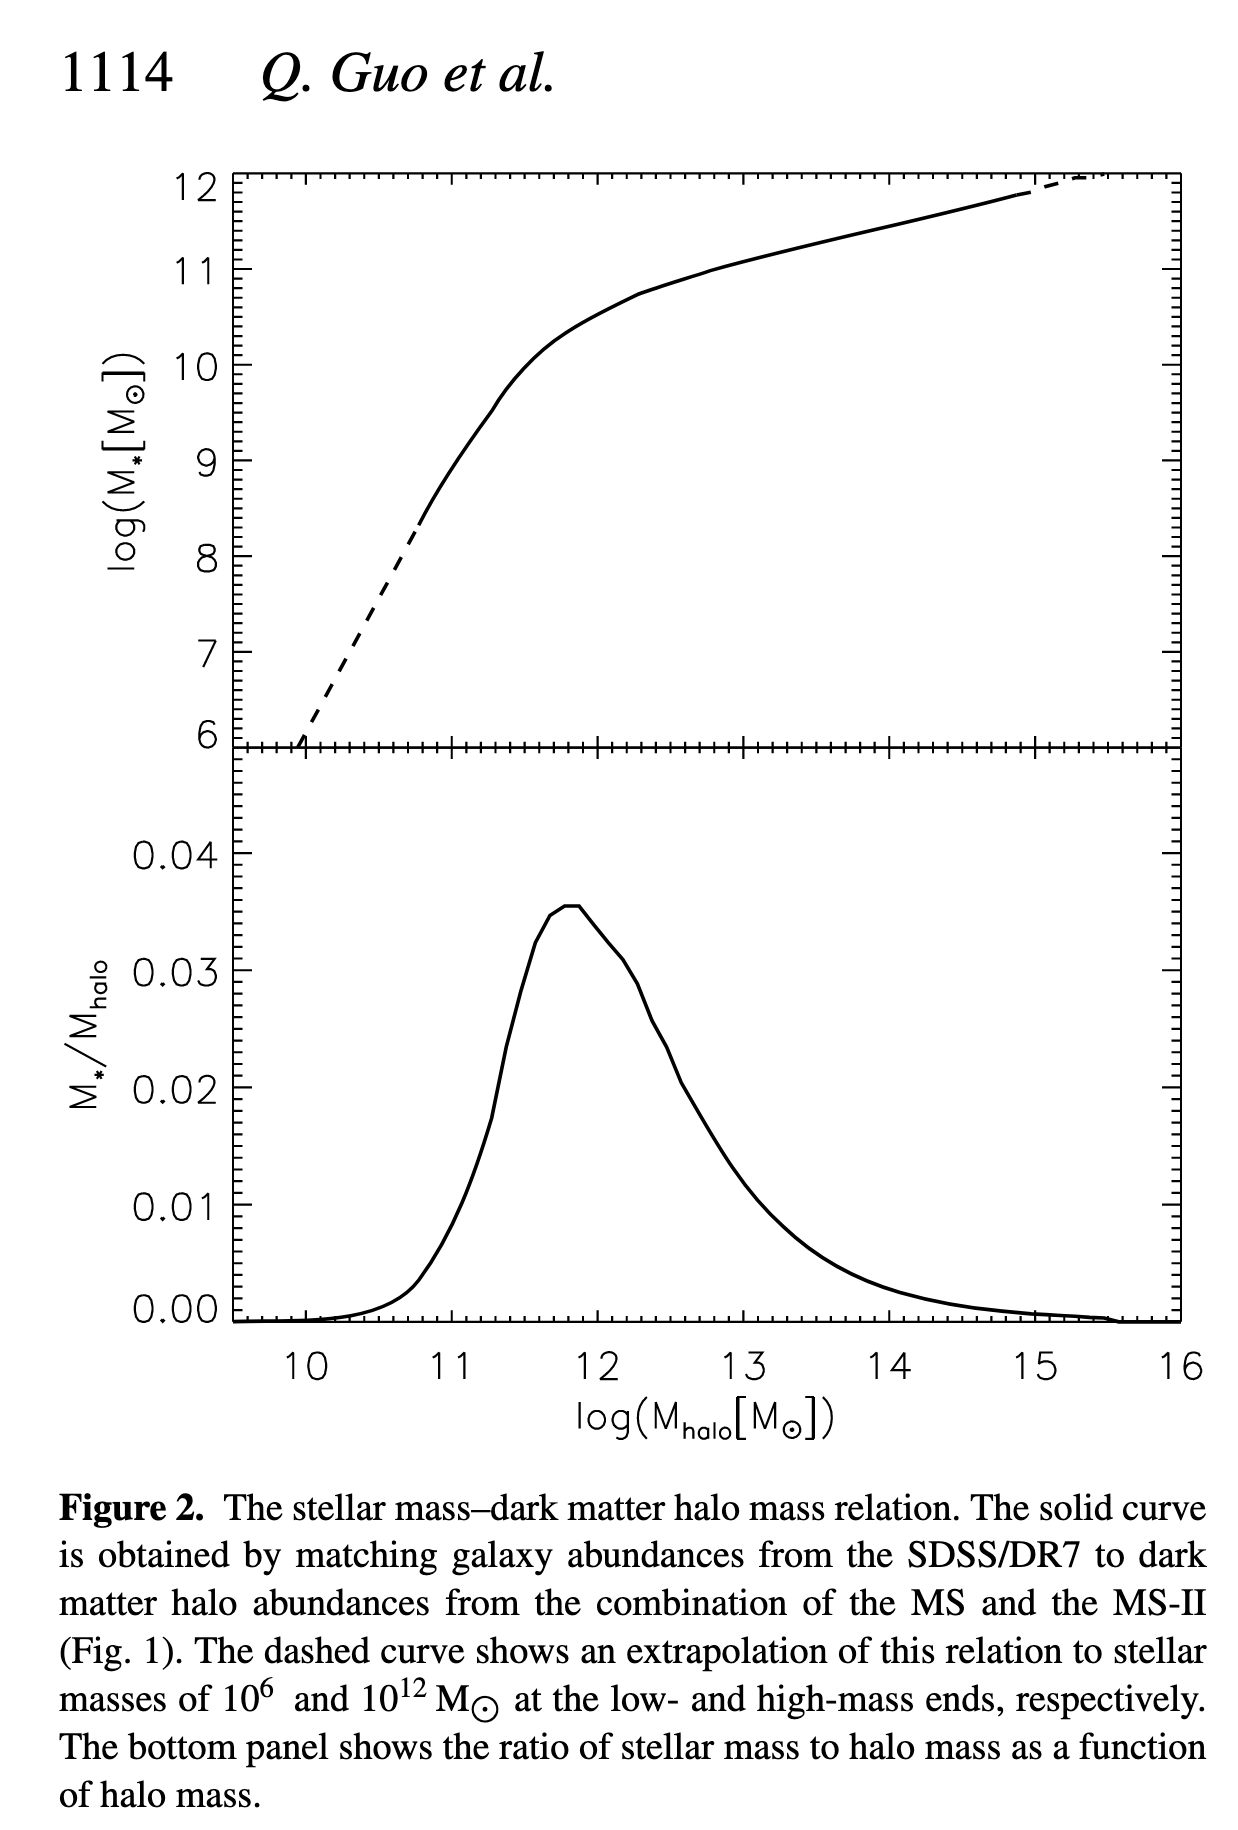
</div>

## Behroozi et al. 2013

In [ ]:
rooz = holo.observations.Behroozi_2013()

In [ ]:
NOTE = """This doesn't match the paper plot well (Behroozi+2013, Fig.7, left-panel)
but I think that's because what they plot is the mean, marginalized over parameter uncertainties,
while this plot is using the mean values of each parameter.  Those aren't the same thing!
"""
print(NOTE)

zlist = [0.1,] + np.arange(1, 9).tolist()
colors = ['k', 'r', 'orange', 'yellow', 'green', 'cyan', 'dodgerblue', 'navy', 'violet']
print(zlist)
limits = [
    [1e10, 1e15],   # k
    [8e10, 6e14],   # r
    [2e11, 1.5e14], # ora
    [3e11, 5e13],   # yel
    [3e11, 3e13],   # grn
    [2e11, 8e12],   # cyan
    [1.5e11, 4e12], # light blue
    [1e10, 4e11],   # dark blue
    [1.5e10, 8e10]  # violet
]


fig, ax = plt.subplots(figsize=[10, 8])
ax.set(xscale='log', yscale='log')
ax.grid(True)

for zz, cc, lim in zip(zlist, colors, limits):
    mstar = rooz.stellar_mass(mhalo * MSOL, zz) / MSOL
    idx = (lim[0] < mhalo) & (mhalo < lim[1])
    # idx = slice(None)
    yy = mstar
    # yy = mstar / mhalo
    ax.plot(mhalo[idx], yy[idx], color=cc, lw=2.0)
    
plt.show()


<b>plot from the paper (Behroozi+2013, Fig.7):</b>
<div>
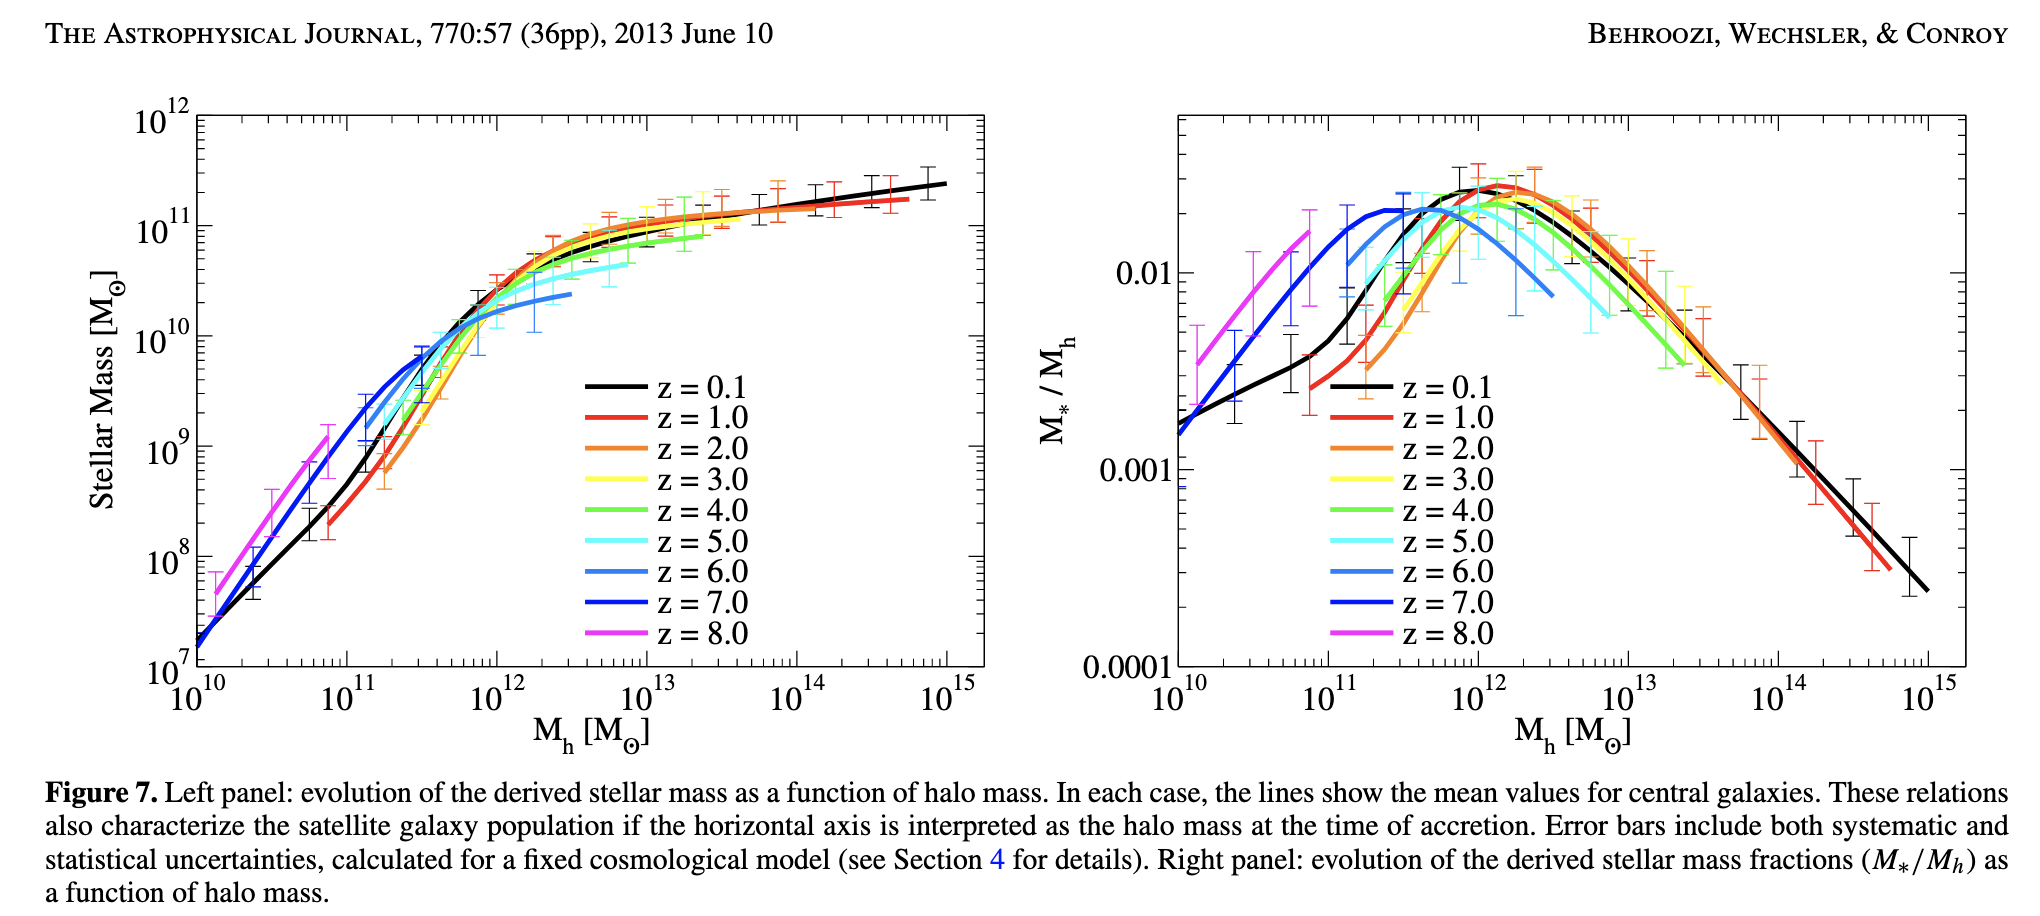
</div>

In [ ]:
redz = np.linspace(0.0, 6.0, 40)
 
mstar = rooz.stellar_mass(mhalo[:, np.newaxis] * MSOL, redz[np.newaxis, :]) / MSOL

### Test/Check interpolation from mstar ==> mhalo

In [ ]:
rooz = holo.observations.Behroozi_2013()

# breaker()

mhalo = rooz._mhalo_grid
redz = rooz._redz_grid
mstar = rooz._mstar

NUM = 30

fig, ax = plt.subplots(figsize=[10, 8])
pcm = ax.pcolormesh(np.log10(mhalo/MSOL), redz, np.log10(mstar/MSOL).T)
cbar = plt.colorbar(pcm, ax=ax)

ss = MSOL * 10.0 ** np.random.uniform(5, 11, NUM)
zz = np.random.uniform(0.0, 9.0, NUM)

hh = rooz.halo_mass(ss, zz)

ss = np.log10(ss/MSOL)
hh = np.log10(hh/MSOL)
cc = cbar.cmap(cbar.norm(ss))

ax.scatter(hh, zz, c=cc, edgecolor='r', lw=1.0, s=100)


plt.show()

# Density Profiles

## NFW

In [ ]:
DENS_UNITS = MSOL / PC ** 3

nfw = holo.observations.NFW
smhm = holo.observations.Behroozi_2013()

fig, ax = plt.subplots(figsize=[15, 10])
ax.set(xscale='log', yscale='log')
ax.grid(True)
tw = ax.twinx()
tw.set(yscale='log')

mstar = 1e11 * MSOL
zlist = [1.0, 2.0, 3.0]
for zz in zlist:
    mhalo = smhm.halo_mass(mstar, zz)
    rscale = nfw.radius_scale(mhalo, zz)

    rads = np.logspace(-3, 3, 100) * rscale
    dens = nfw.density(rads, mhalo, zz)
    hh, = ax.plot(rads/PC, dens/DENS_UNITS, label=zz)
    cc = hh.get_color()
    ax.axvline(rscale/PC, color=cc, ls=':')
    
    mass = nfw.mass(rads, mhalo, zz)
    tw.plot(rads/PC, mass/MSOL, ls='--')
    tw.axhline(mhalo/MSOL, color=cc, ls=':')

ax.legend()
plt.show()
    

In [ ]:
xx = np.logspace(1, 4, 4) * PC
nfw.time_dynamical(xx, 1e15, 1.0)/GYR